# Performance evaluation notebook

In [1]:
import numpy as np
from sklearn import metrics
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

def get_op_threshold(pred, true):
    fpr, tpr, threshold = metrics.roc_curve(true, pred)
    op = np.argmin(np.abs(tpr - (1 - fpr)))
    return threshold[op]

def get_sens_spec_at_threshold(true, pred, op=.5):
    sens = metrics.recall_score(true, pred >= op, pos_label=1, zero_division=1)
    spec = metrics.recall_score(true, pred >= op, pos_label=0, zero_division=1)
    return sens, spec

In [2]:
data_dir = Path("/cxr/tables")
test_df = pd.read_csv("/shared/team6/test_df.csv")
predictions = pd.read_csv("~/mllss2/predictions.csv")
test_df = pd.concat([test_df, predictions], axis=1)

In [3]:
meta_df = pd.read_csv(data_dir / "datathon_cxr_metadata.csv")
insurance_df = pd.read_csv(data_dir / "datathon_cxr_insurance.csv")
adi_df = pd.read_csv(data_dir / "datathon_cxr_adi.csv")
meta_test = pd.merge(test_df, meta_df, on="ImagePath")

In [4]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(meta_test["Cardiomegaly"], meta_test["Pred_Cardiomegaly"])

In [5]:
op_cardio = get_op_threshold(meta_test["Pred_Cardiomegaly"], meta_test["Cardiomegaly"])
op_pleural = get_op_threshold(meta_test["Pred_Pleural"], meta_test["Pleural Effusion"])
op_pneumo = get_op_threshold(meta_test["Pred_Pneumothorax"], meta_test["Pneumothorax"])

In [6]:
meta_test.rename(columns={"AccessionNumber_anon_x": "AccessionNumber_anon", "empi_anon_x": "empi_anon"}, inplace=True)

# Performance by Insurance

In [7]:
from sklearn.metrics import roc_auc_score
roc_auc_score(meta_test["Cardiomegaly"], meta_test["Pred_Cardiomegaly"])
get_sens_spec_at_threshold(meta_test["Cardiomegaly"], meta_test["Pred_Cardiomegaly"], op=op_cardio)

(0.7740811476724352, 0.7740828494805634)

In [8]:
merged_insurance = pd.merge(meta_test, insurance_df, on=["empi_anon", "StudyDate_anon"], how="inner")

In [9]:
insurance_mapping = {
    "HMO": "Private",
    "BLUE CROSS": "Private",
    "MEDICAID": "Medicaid",
    "MEDICARE": "Medicare",
    "OTHER": "Other",
    "PPO": "Private",
    'SELF PAY': "Self Pay",
    "OUTSOURCED": "Other",
    "Not Recorded": "Not Recorded"
}
merged_insurance["custom_insurance_category"] = merged_insurance.INSURANCE.apply(lambda x: insurance_mapping[x])

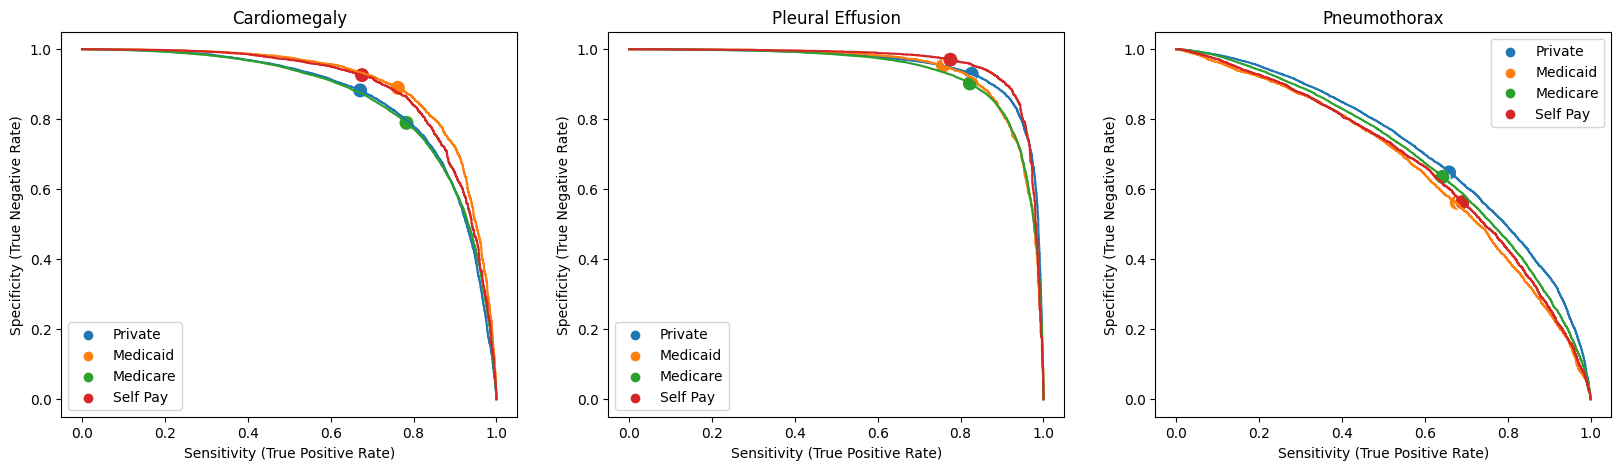

In [33]:
from sklearn.metrics import roc_curve
a_sens_card = []
a_spec_card = []
a_sens_pneumo = []
a_spec_pneumo = []
a_sens_pleural = []
a_spec_pleural = []
insurance_x_axis = []

f, ax = plt.subplots(1, 3, figsize=(20,5))

for insurance_type in merged_insurance["custom_insurance_category"].unique():
    if insurance_type not in ["Other", "Not Recorded"]:
        df = merged_insurance.loc[merged_insurance["custom_insurance_category"] == insurance_type]
        sens_cardio, spec_cardio = get_sens_spec_at_threshold(df["Cardiomegaly"], df["Pred_Cardiomegaly"], op=op_cardio)
        fpr_a, tpr_a, _ = roc_curve(df["Cardiomegaly"], df["Pred_Cardiomegaly"])
        ax[0].plot(tpr_a, 1-fpr_a)
        sens_pleural, spec_pleural = get_sens_spec_at_threshold(df["Pleural Effusion"], df["Pred_Pleural"], op=op_pleural)
        fpr_a, tpr_a, _ = roc_curve(df["Pleural Effusion"], df["Pred_Pleural"])
        ax[1].plot(tpr_a, 1-fpr_a)
        sens_pneumo, spec_pneumo = get_sens_spec_at_threshold(df["Pneumothorax"], df["Pred_Pneumothorax"], op=op_pneumo)
        fpr_a, tpr_a, _ = roc_curve(df["Pneumothorax"], df["Pred_Pneumothorax"])
        ax[2].plot(tpr_a, 1-fpr_a)
        a_sens_card.append(sens_cardio)
        a_spec_card.append(spec_cardio)
        a_sens_pleural.append(sens_pleural)
        a_spec_pleural.append(spec_pleural)
        a_sens_pneumo.append(sens_pneumo)
        a_spec_pneumo.append(spec_pneumo)
        insurance_x_axis.append(insurance_type)

sns.scatterplot(x=a_sens_card, y=a_spec_card, hue=insurance_x_axis, ax=ax[0],s=120)
sns.scatterplot(x=a_sens_pleural, y=a_spec_pleural, hue=insurance_x_axis, ax=ax[1],s=120)
sns.scatterplot(x=a_sens_pneumo, y=a_spec_pneumo, hue=insurance_x_axis, ax=ax[2],s=120)
ax[0].set_title("Cardiomegaly")
ax[1].set_title("Pleural Effusion")
ax[2].set_title("Pneumothorax")
for i in range(3):
    ax[i].set_xlabel("Sensitivity (True Positive Rate)")
    ax[i].set_ylabel("Specificity (True Negative Rate)")

# RACE

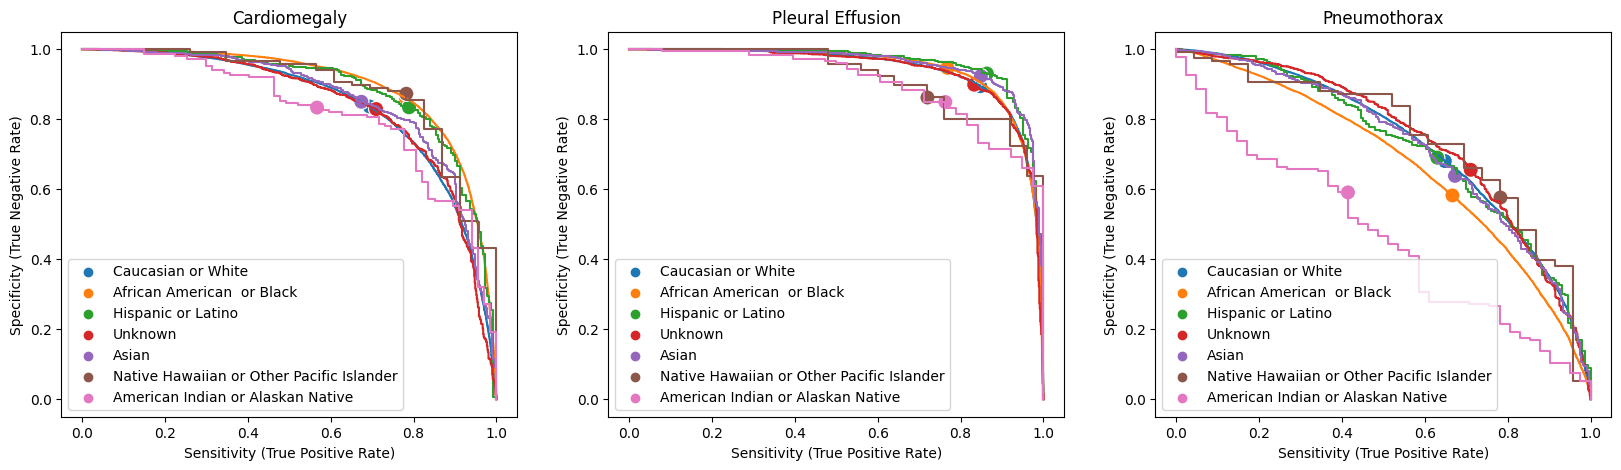

In [32]:
from sklearn.metrics import roc_curve
a_sens_card = []
a_spec_card = []
a_sens_pneumo = []
a_spec_pneumo = []
a_sens_pleural = []
a_spec_pleural = []
insurance_x_axis = []

f, ax = plt.subplots(1, 3, figsize=(20,5))

for insurance_type in merged_insurance["Race"].unique():
    #if insurance_type in ["Caucasian or White", "African American or Black", "Asian", "Hispanic or Latino"]:
    df = merged_insurance.loc[merged_insurance["Race"] == insurance_type]
    sens_cardio, spec_cardio = get_sens_spec_at_threshold(df["Cardiomegaly"], df["Pred_Cardiomegaly"], op=op_cardio)
    fpr_a, tpr_a, _ = roc_curve(df["Cardiomegaly"], df["Pred_Cardiomegaly"])
    ax[0].plot(tpr_a, 1-fpr_a)
    sens_pleural, spec_pleural = get_sens_spec_at_threshold(df["Pleural Effusion"], df["Pred_Pleural"], op=op_pleural)
    fpr_a, tpr_a, _ = roc_curve(df["Pleural Effusion"], df["Pred_Pleural"])
    ax[1].plot(tpr_a, 1-fpr_a)
    sens_pneumo, spec_pneumo = get_sens_spec_at_threshold(df["Pneumothorax"], df["Pred_Pneumothorax"], op=op_pneumo)
    fpr_a, tpr_a, _ = roc_curve(df["Pneumothorax"], df["Pred_Pneumothorax"])
    ax[2].plot(tpr_a, 1-fpr_a)
    a_sens_card.append(sens_cardio)
    a_spec_card.append(spec_cardio)
    a_sens_pleural.append(sens_pleural)
    a_spec_pleural.append(spec_pleural)
    a_sens_pneumo.append(sens_pneumo)
    a_spec_pneumo.append(spec_pneumo)
    insurance_x_axis.append(insurance_type)

sns.scatterplot(x=a_sens_card, y=a_spec_card, hue=insurance_x_axis, ax=ax[0],s=120)
sns.scatterplot(x=a_sens_pleural, y=a_spec_pleural, hue=insurance_x_axis, ax=ax[1],s=120)
sns.scatterplot(x=a_sens_pneumo, y=a_spec_pneumo, hue=insurance_x_axis, ax=ax[2],s=120)
ax[0].set_title("Cardiomegaly")
ax[1].set_title("Pleural Effusion")
ax[2].set_title("Pneumothorax")
for i in range(3):
    ax[i].set_xlabel("Sensitivity (True Positive Rate)")
    ax[i].set_ylabel("Specificity (True Negative Rate)")

# Sex

In [36]:
merged_adi = pd.merge(meta_test, adi_df, on=["empi_anon"], how="inner")

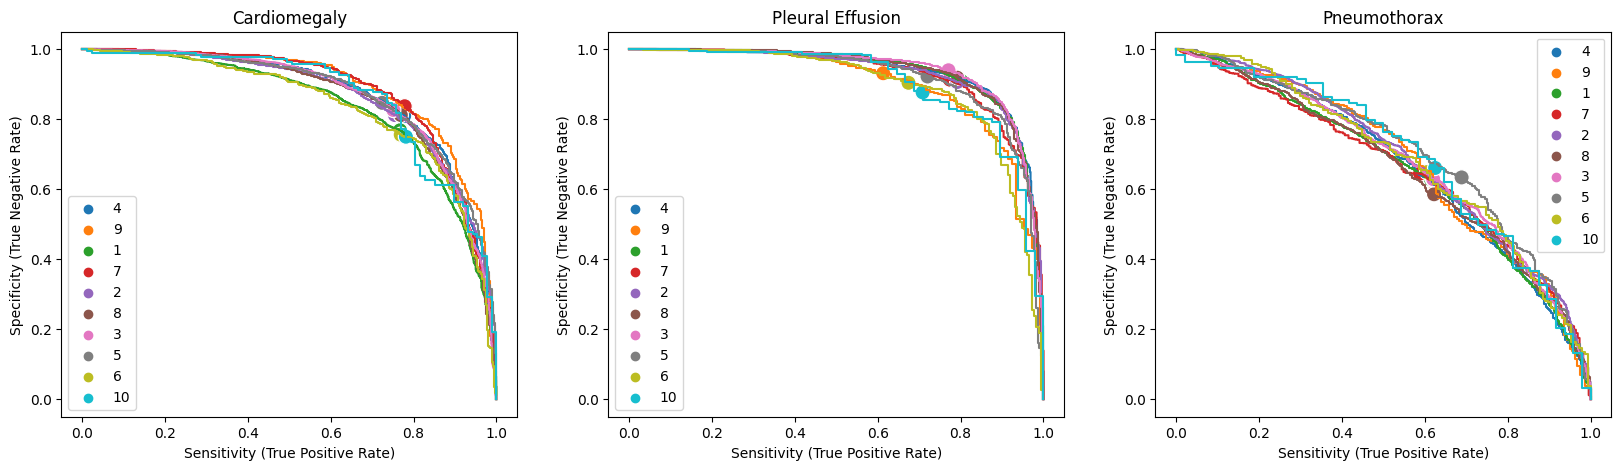

In [45]:
from sklearn.metrics import roc_curve
a_sens_card = []
a_spec_card = []
a_sens_pneumo = []
a_spec_pneumo = []
a_sens_pleural = []
a_spec_pleural = []
insurance_x_axis = []

f, ax = plt.subplots(1, 3, figsize=(20,5))

for insurance_type in merged_adi["ADI_STATERNK"].unique():
    #if insurance_type in ["Caucasian or White", "African American or Black", "Asian", "Hispanic or Latino"]:
    df = merged_adi.loc[merged_adi["ADI_STATERNK"] == insurance_type]
    sens_cardio, spec_cardio = get_sens_spec_at_threshold(df["Cardiomegaly"], df["Pred_Cardiomegaly"], op=op_cardio)
    fpr_a, tpr_a, _ = roc_curve(df["Cardiomegaly"], df["Pred_Cardiomegaly"])
    ax[0].plot(tpr_a, 1-fpr_a)
    sens_pleural, spec_pleural = get_sens_spec_at_threshold(df["Pleural Effusion"], df["Pred_Pleural"], op=op_pleural)
    fpr_a, tpr_a, _ = roc_curve(df["Pleural Effusion"], df["Pred_Pleural"])
    ax[1].plot(tpr_a, 1-fpr_a)
    sens_pneumo, spec_pneumo = get_sens_spec_at_threshold(df["Pneumothorax"], df["Pred_Pneumothorax"], op=op_pneumo)
    fpr_a, tpr_a, _ = roc_curve(df["Pneumothorax"], df["Pred_Pneumothorax"])
    ax[2].plot(tpr_a, 1-fpr_a)
    a_sens_card.append(sens_cardio)
    a_spec_card.append(spec_cardio)
    a_sens_pleural.append(sens_pleural)
    a_spec_pleural.append(spec_pleural)
    a_sens_pneumo.append(sens_pneumo)
    a_spec_pneumo.append(spec_pneumo)
    insurance_x_axis.append(str(insurance_type))

sns.scatterplot(x=a_sens_card, y=a_spec_card, hue=insurance_x_axis, ax=ax[0],s=120)
sns.scatterplot(x=a_sens_pleural, y=a_spec_pleural, hue=insurance_x_axis, ax=ax[1],s=120)
sns.scatterplot(x=a_sens_pneumo, y=a_spec_pneumo, hue=insurance_x_axis, ax=ax[2],s=120)
ax[0].set_title("Cardiomegaly")
ax[1].set_title("Pleural Effusion")
ax[2].set_title("Pneumothorax")
for i in range(3):
    ax[i].set_xlabel("Sensitivity (True Positive Rate)")
    ax[i].set_ylabel("Specificity (True Negative Rate)")

In [40]:
merged_adi

,Unnamed: 0,AccessionNumber_anon,empi_anon,ImagePath,Cardiomegaly,Pleural Effusion,Pneumothorax,ImageView_Lateral_x,Unnamed: 0,Pred_Cardiomegaly,...,ImageView_Frontal,ImageView_Lateral_y,ADI_x,ICU,Findings,CCI,Insurance,ADI_NATRANK,ADI_STATERNK,ADI_y
0,11,9148955839141307,27175152,CXR/0x19ea8f0/0x2080ed46db95bb/dcd75590671be01...,1.0,0.0,1.0,0,5,0.567362,...,1,0,1,0,1,1,1,49.0,4,0
1,11772,7418571930337330,27175152,CXR/0x19ea8f0/0x1a5b26e0a60032/2e7058a1360221f...,1.0,0.0,0.0,0,3772,0.661733,...,1,0,1,0,1,1,1,49.0,4,0
2,13514,9958911327090511,27175152,CXR/0x19ea8f0/0x236193bc00374f/27ecbb6c366b0e8...,1.0,0.0,0.0,0,4316,0.036938,...,1,0,1,0,1,1,1,49.0,4,0
3,34808,9256859179016656,27175152,CXR/0x19ea8f0/0x20e3107b19e1d0/13d540538ffda45...,0.0,0.0,0.0,0,11118,0.252466,...,1,0,1,0,1,1,1,49.0,4,0
4,45841,1316868193171507,27175152,CXR/0x19ea8f0/0x4adaf44deb833/2fe77576a92f70f0...,0.0,1.0,1.0,0,14594,0.518882,...,1,0,1,1,1,1,1,49.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25255,741193,2237672875480058,67386961,CXR/0x4043e51/0x7f326d0ddd3fa/0c68e07a237cb730...,0.0,0.0,0.0,0,259313,0.137108,...,1,0,1,0,1,1,1,29.0,2,0
25256,741523,4995077494043472,82950689,CXR/0x4f1ba21/0x11beff1ba87350/48a61f1641eb736...,0.0,0.0,0.0,0,259525,0.067023,...,1,0,1,0,1,1,1,23.0,2,0
25257,741661,9888079454392603,80286697,CXR/0x4c913e9/0x232127e763d11b/aa7c4bf417e1d05...,0.0,0.0,0.0,0,259624,0.043235,...,1,0,1,0,1,1,0,29.0,2,0
25258,741765,6636347898310454,27123613,CXR/0x19ddf9d/0x1793b92715af36/280f5075a2352e9...,0.0,0.0,0.0,0,259692,0.089344,...,1,0,1,0,1,1,0,71.0,7,0
